# Bayesian Logistic Regression Example

In [ ]:
# Author: jake-westfall
# Created At: Sep 11, 2016
# Last Run: Mar 27, 2019

In [1]:
import bambi as bmb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

In [2]:
az.style.use('arviz-darkgrid')

## Load and examine American National Election Studies (ANES) data
These data are from the 2016 pilot study. The full study consisted of 1200 people, but here we've selected the subset of 487 people who responded to a question about whether they would vote for Hillary Clinton or Donald Trump. 

In [3]:
data = pd.read_csv('data/ANES_2016_pilot.csv')
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Our outcome variable is `vote`, which gives peoples' responses to the following question prompt:

*"If the 2016 presidential election were between Hillary Clinton for the Democrats and Donald Trump for the Republicans, would you vote for Hillary Clinton, Donald Trump, someone else, or probably not vote?"*

In [4]:
data['vote'].value_counts()

clinton         215
trump           158
someone_else     48
Name: vote, dtype: int64

The two predictors we'll examine are a respondent's `age` and their political party affiliation, `party_id`, which is their response to the following question prompt:

*"Generally speaking, do you usually think of yourself as a Republican, a Democrat, an
independent, or what?"*

In [5]:
data['party_id'].value_counts()

democrat       186
independent    138
republican      97
Name: party_id, dtype: int64

These two predictors are somewhat correlated, but not all that much:

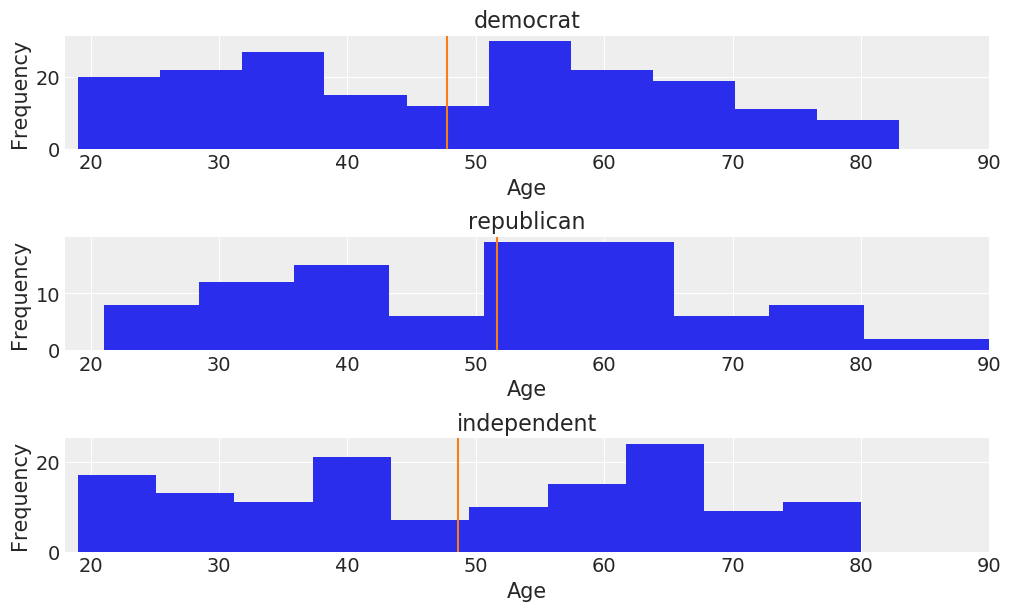

In [6]:
fig, ax = plt.subplots(3, figsize=(10, 6), constrained_layout=True)
key = dict(zip(data['party_id'].unique(), range(3)))
for label, df in data.groupby('party_id'):
    ax[key[label]].hist(df['age'])
    ax[key[label]].set_xlim([18, 90])
    ax[key[label]].set_xlabel('Age')
    ax[key[label]].set_ylabel('Frequency')
    ax[key[label]].set_title(label)
    ax[key[label]].axvline(df['age'].mean(), color='C1')

We can get a pretty clear idea of how party identification is related to voting intentions by just looking at a contingency table for these two variables:

In [7]:
pd.crosstab(data['vote'], data['party_id'])

party_id,democrat,independent,republican
vote,,,
clinton,159,51,5
someone_else,10,22,16
trump,17,65,76


But our main question here will be: How is respondent age related to voting intentions, and is this relationship different for different party affiliations? For this we will need logistic regression.

## Build `clinton_model`

To keep this simple, let's look at only the data from people who indicated that they would vote for either Clinton or Trump, and we'll model the probability of voting for Clinton.

In [8]:
clinton_data = data.loc[data['vote'].isin(['clinton', 'trump']), :]
clinton_data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Specifying and fitting the model is simple. Notice the (optional) syntax that we use on the left-hand-side of the formula: We say `vote[clinton]` to instruct bambi that we wish the model the probability that `vote=='clinton'`, rather than the probability that `vote=='trump'`. If we leave this unspecified, bambi will just pick one of the events to model, but will inform you which one it picked when you build the model (and again when you look at model summaries.) 

When fitting models using the `pymc3` backend, the default estimation strategy is to start with an identity mass matrix, but add uniform jitter in [-1, 1] and then adapt a diagonal based on the variance of the tuning samples. This generally works quite well, but occasionally it can fails. That's what was happening for this particular data set and model, so below we disable the `jitter+adapt_diag` initialization by changing from `init='auto'` (the default) to `init=None`, which tells the `pymc3` backend to jump straight to the MCMC sampling.

In [9]:
clinton_model = bmb.Model(clinton_data)
clinton_fitted = clinton_model.fit('vote[clinton] ~ party_id + party_id:age',
                                   family='bernoulli', samples=1000, init=None)

/home/osvaldo/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/osvaldo/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/osvaldo/proyectos/00_PyMC3/bambi/bambi/models.py:258: UserWarning: Modeling the probability that vote=='clinton'
  self.y.name, str(self.clean_data[self.y.name].iloc[event])
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [party_id:age, party_id, Intercept]
INFO:pymc3:NUTS: [party_id:age, party_id, Intercept]
100%|██████████| 1500/1500 [0

Since we didn't explicitly set any of the prior distributions, here's a view of what the default priors look like for all parameters:

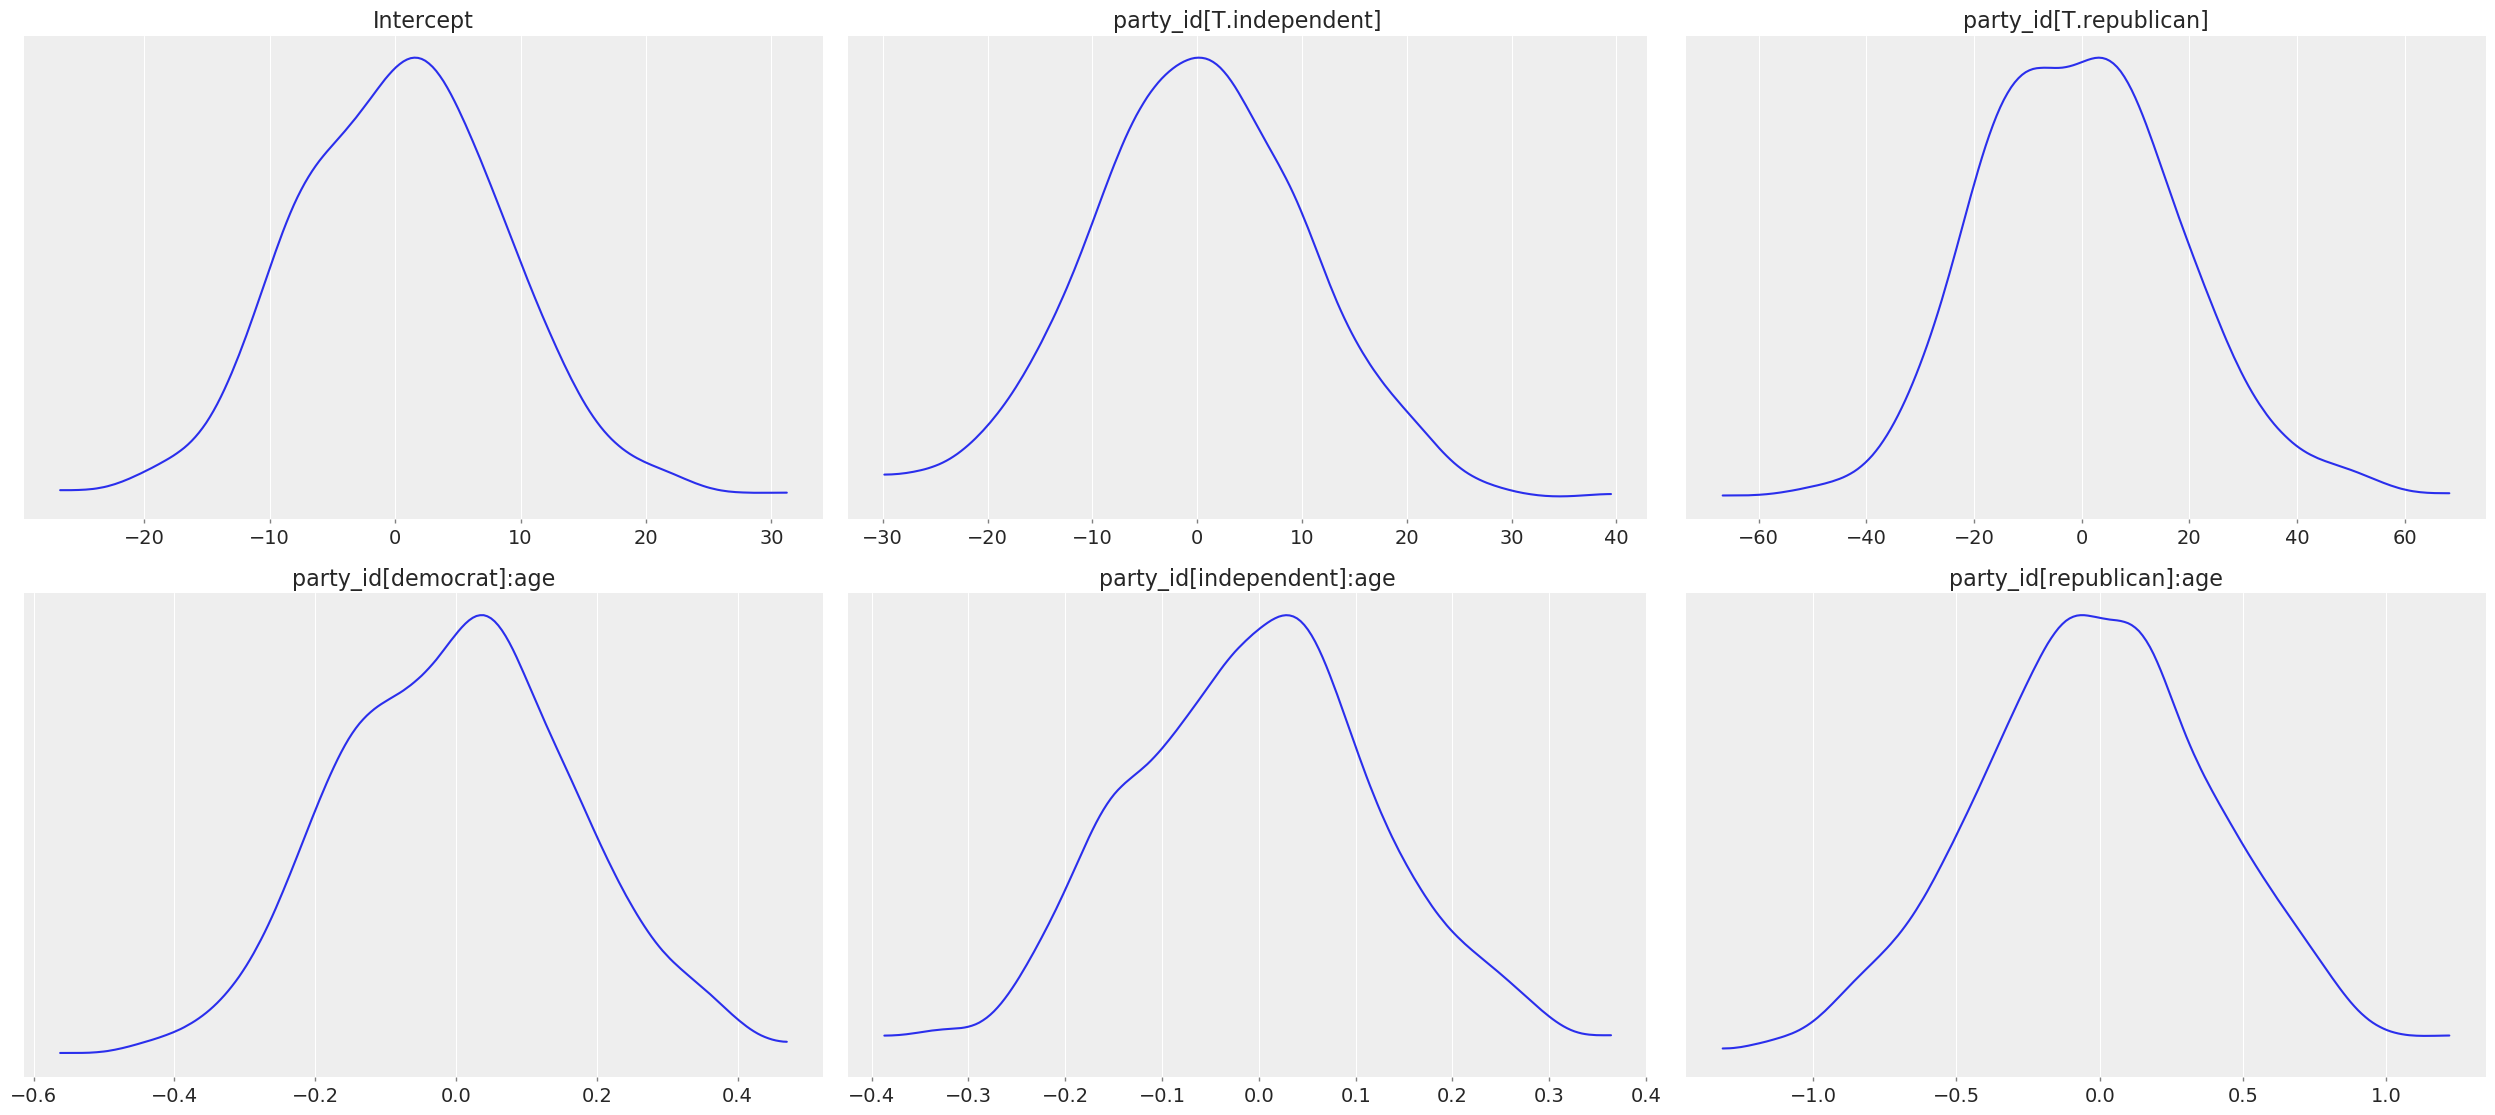

In [10]:
clinton_model.plot();

In [11]:
{x.name: x.prior.args for x in clinton_model.terms.values()}

{'Intercept': {'mu': array([0.308043]), 'sd': array([8.39859892])},
 'party_id': {'mu': array([0, 0]), 'sd': array([10.51415445, 18.72417819])},
 'party_id:age': {'mu': array([0, 0, 0]),
  'sd': array([0.16748696, 0.12909332, 0.40771782])}}

Some more info about these default priors can be found in [this technical paper](https://arxiv.org/abs/1702.01201).

Now let's check out the the results!

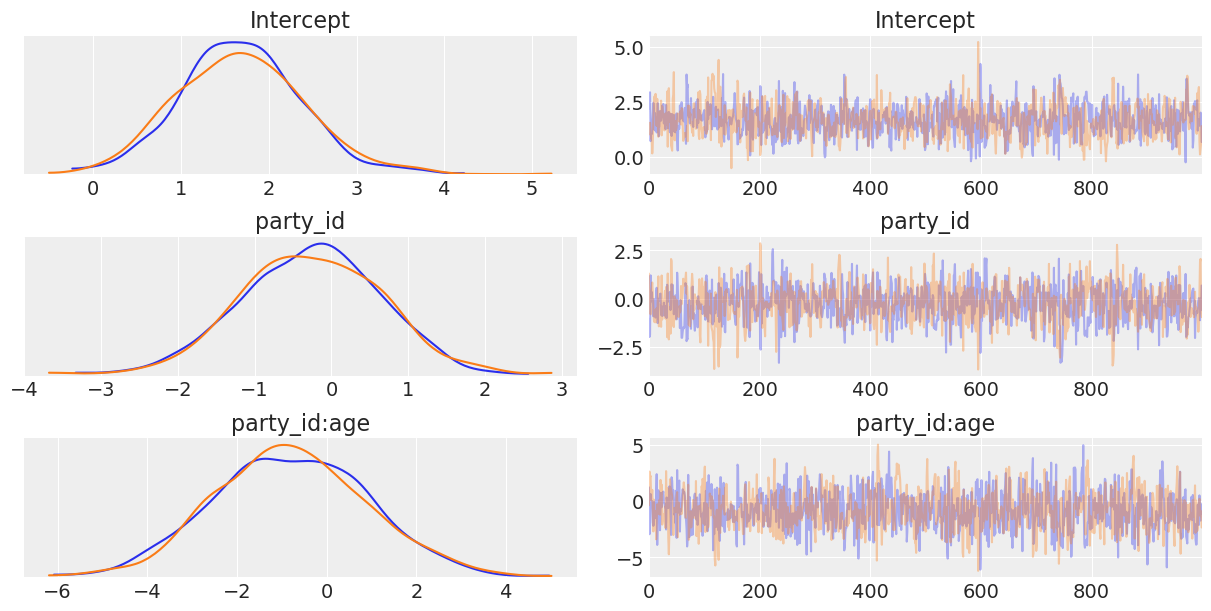

In [12]:
clinton_fitted.plot();

In [13]:
clinton_fitted.summary()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,1.681,0.705,0.346,2.967,0.023,0.017,951.0,897.0,984.0,832.0,1.0
party_id,-0.273,0.933,-2.035,1.372,0.029,0.024,1037.0,768.0,1050.0,1064.0,1.0
party_id:age,-0.798,1.689,-3.863,2.402,0.051,0.036,1095.0,1080.0,1097.0,1115.0,1.0


## Run Inference

Grab the posteriors samples of the `age` slopes for the three `party_id` categories.

In [14]:
parties = ['democrat', 'independent', 'republican']
dem, ind, rep = [clinton_fitted.to_df()['party_id[{}]:age'.format(x)]
                 for x in parties]

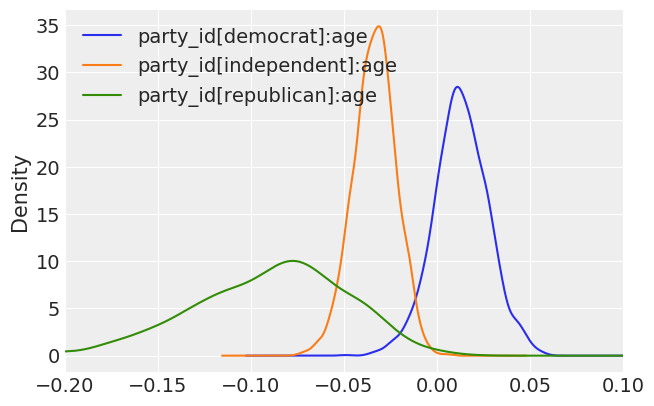

In [15]:
for x in [dem, ind, rep]:
    x.plot(kind='kde', xlim=[-.2, .1])
plt.legend(loc='upper left')

What is the probability that the Democrat slope is greater than the Republican slope?

In [16]:
(dem > rep).mean()

0.9965

Probability that the Democrat slope is greater than the Independent slope?

In [17]:
(dem > ind).mean()

0.989

Probability that the Independent slope is greater than the Republican slope?

In [18]:
(ind > rep).mean()

0.9175

Probability that the Democrat slope is greater than 0?

In [19]:
(dem > 0).mean()

0.8285

Probability that the Republican slope is less than 0?

In [20]:
(rep < 0).mean()

0.995

Probability that the Independent slope is less than 0?

In [21]:
(ind < 0).mean()

0.9985

## Spaghetti plot of model predictions

Grab all the MCMC samples.

In [22]:
trace_df = clinton_fitted.to_df()
trace_df.head()

,Intercept,party_id[T.independent],party_id[T.republican],party_id[democrat]:age,party_id[independent]:age,party_id[republican]:age
0,2.209430,-1.050688,1.220060,0.000763,-0.027360,-0.136536
1,2.917040,-1.990333,-2.939985,-0.018007,-0.017067,-0.072577
2,2.936004,-1.879232,-2.081409,-0.003815,-0.026302,-0.096153
3,0.721475,1.205264,0.624114,0.029420,-0.042630,-0.105370
4,1.490932,-0.034994,-0.197276,0.014456,-0.036097,-0.106004


Separate this into two DataFrames, one containing the intercept for each `party_id`, the other containing the `age` slopes for each `party_id`.

In [23]:
slopes = trace_df.iloc[:, -3:]
intercepts = pd.DataFrame({
    'dem': trace_df['Intercept'],
    'ind': trace_df['Intercept'] + trace_df['party_id[T.independent]'],
    'rep': trace_df['Intercept'] + trace_df['party_id[T.republican]']
})

Compute the predicted values for each posterior sample.

In [24]:
def invlogit(x): return 1/(1+np.exp(-x))


X = np.hstack([np.array([1]*len(np.arange(18, 91)))[:, None],
               np.arange(18, 91)[:, None]])
yhat = [invlogit(np.dot(X, np.vstack([intercepts.iloc[:, i], slopes.iloc[:, i]])))
        for i in range(3)]

Make the plot!

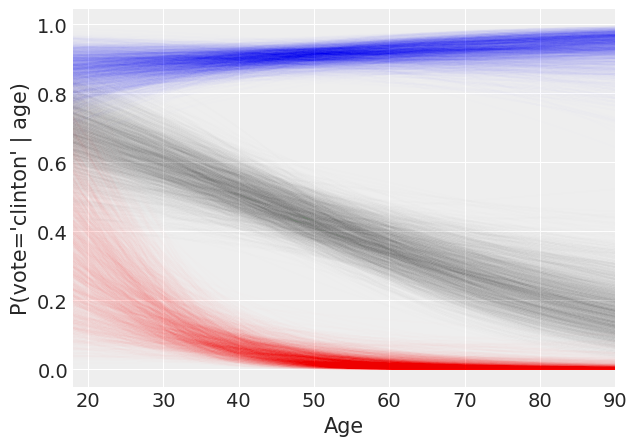

In [26]:
fig, axes = plt.subplots(figsize=(7, 5))

cols = ['b', 'g', 'r']
for i in range(3):
    for t in range(len(trace_df.index)):
        axes.plot(X[:, 1], yhat[i][:, t], alpha=.005, color=cols[i])
axes.set_ylabel('P(vote=\'clinton\' | age)', fontsize=15)
axes.set_xlabel('Age', fontsize=15)
axes.set_xlim(18, 90);